# A2C

In [ ]:
import numpy as np
import torch as th
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch.nn.functional as F
from torch.distributions import Categorical
import scipy.stats as st
import gym
import cv2

# Environment

In [ ]:
class CartPole:
    def __init__(self, env_name):
        self.env = gym.make(env_name)
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space

    def reset(self):
        return self.env.reset()

    def step(self, action):
        return self.env.step(action)

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()

In [ ]:
class PongEnv:
    def __init__(self, env_name):
        self.env = gym.make(env_name)

    def reset(self):
        return self.env.reset()

    def step(self, action):
        return self.env.step(action)

    def close(self):
        self.env.close()

    def state_to_tensor(self, It):
        """ prepro 210x160x3 uint8 frame into 6000 (75x80) 1D float vector. See Karpathy's post: http://karpathy.github.io/2016/05/31/rl/ """
        if It is None:
        #if len(I) == 0:
            return torch.zeros(1, 6000)
        if len(It) == 2:  # It is a tuple or a matrix
            I = It[0]
        else:
            I = It
        I = I[35:185] # crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle)
        I = I[::2,::2,0] # downsample by factor of 2.
        I[I == 144] = 0 # erase background (background type 1)
        I[I == 109] = 0 # erase background (background type 2)
        I[I != 0] = 1 # everything else (paddles, ball) just set to 1. this makes the image grayscale effectively
        return torch.from_numpy(I.astype(np.float32).ravel()).unsqueeze(0)

    def pre_process(self, x, prev_x):
        aa = self.state_to_tensor(x)
        bb = self.state_to_tensor(prev_x)
        return aa - bb

# Actor

In [ ]:
class A2CActor(th.nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
      super(A2CActor, self).__init__()

      # Define Layers
      self.fc1 = th.nn.Linear(state_size, hidden_size)
      self.fc2 = th.nn.Linear(hidden_size, hidden_size)
      self.fc3 = th.nn.Linear(hidden_size, action_size)

    def forward(self, state):
        # Build networ that maps state -> logits
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)

        return logits

    def action_sampler(self, logits):
        softmax_probabilities = F.softmax(logits, dim=-1)
        action_dist = th.distributions.categorical.Categorical(softmax_probabilities)
        action = action_dist.sample()
        return action, action_dist

# Critic

In [ ]:
class A2CCritic(th.nn.Module):
    def __init__(self, state_size, hidden_size, value_size):
        super(A2CCritic, self).__init__()

        # Define Layers
        self.fc1 = th.nn.Linear(state_size, hidden_size)
        self.fc2 = th.nn.Linear(hidden_size, hidden_size)
        self.fc3 = th.nn.Linear(hidden_size, value_size)

    def forward(self, state):
        # Build network that maps state -> value
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)

        return value


# Helpers

In [ ]:
# Helper function to convert numpy arrays to tensors
def to_tensor(x):
    if isinstance(x, np.ndarray):
        return th.from_numpy(x).float()
    return x

def initialize_environment(env_name):
    if 'PongNoFrameskip-v4' in env_name:
        env = PongEnv(env_name)
        state_dim = 6000
        action_dim = 2
        action_offset = 2
    else:
        env = CartPole(env_name)
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        action_offset = 0

    return env, state_dim, action_dim, action_offset

# Batch Training

In [ ]:
class BatchTraining:
    def __init__(self):
        pass

    def collate_batch(self, buffer, rtrns):
        batch_states = []
        batch_actions = []
        batch_rewards = []
        batch_next_states = []
        batch_rtrns = []

        # Extract data from buffer
        for (data, rtrn) in zip(buffer, rtrns):
            state, action, reward, next_state = data
            batch_states.append(state)
            batch_actions.append(action)
            batch_rewards.append(reward)
            batch_next_states.append(next_state)
            batch_rtrns.append(rtrn)

        batch_states = th.stack(batch_states)
        batch_actions = th.stack(batch_actions)
        batch_rewards = th.tensor(batch_rewards, dtype=th.float32)
        batch_next_states = th.stack(batch_next_states)
        batch_rtrns = th.tensor(batch_rtrns, dtype=th.float32)

        return batch_states, batch_actions, batch_rewards, batch_next_states, batch_rtrns

# Train Loop


In [ ]:
def train(env, state_dim, action_dim, action_offset ,gamma, actor_hidden_dim, critic_hidden_dim,
          value_dim, alpha, beta, num_training_episodes ,num_batch_episodes, t_max, tau,
          test_interval, num_test_episodes, batch_size):
    actor = A2CActor(state_dim, action_dim, actor_hidden_dim)
    critic = A2CCritic(state_dim, critic_hidden_dim, value_dim)

    optimizer_actor = th.optim.Adam(actor.parameters(), lr=alpha)
    optimizer_critic = th.optim.Adam(critic.parameters(), lr=beta)

    episode_rewards = []
    test_rewards = []

    episode = 0

    for te in range(num_training_episodes):
        batch_buffer = []
        batch_rtrns = []
        for e in range(num_batch_episodes):
            state = env.reset()
            prev_state = None
            total_reward = 0
            done = False
            t = 0
            buffer = []

            while not done and (t < t_max):

                if isinstance(env, PongEnv):
                    state_tensor = env.pre_process(state, prev_state)
                else:
                    state_tensor = to_tensor(state)
                logits = actor(state_tensor)
                action, dist = actor.action_sampler(logits)
                converted_action = action.item() + action_offset
                next_state, reward, done, info = env.step(converted_action)
                if isinstance(env, PongEnv):
                    next_state_tensor = env.pre_process(next_state, state)
                else:
                    next_state_tensor = to_tensor(next_state)

                buffer.append((state_tensor, action, reward, next_state_tensor))
                prev_state = state
                state = next_state
                total_reward += reward
                t+=1

            episode_rewards.append(total_reward)
            episode += 1

            rtrns = []
            if done:
                R = 0
            else:
                R = critic(to_tensor(state)).detach().item()

            for _, _, reward, _ in reversed(buffer):
                R = reward + gamma * R
                rtrns.append(R)
            rtrns.reverse()

            batch_buffer.extend(buffer)
            batch_rtrns.extend(rtrns)

            if episode % test_interval == 0:
                actor_state = actor.state_dict()

                test_reward = test(env, actor, num_test_episodes, t_max, action_offset)
                test_rewards.append(test_reward)

                actor.load_state_dict(actor_state)

        batch_training = BatchTraining()
        batch_states, batch_actions, batch_rewards, batch_next_states, batch_rtrns = batch_training.collate_batch(batch_buffer, batch_rtrns)

        # Update Critic
        optimizer_critic.zero_grad()
        V = critic(batch_states)
        # Critic Loss
        critic_loss = (batch_rtrns - V).pow(2).mean()
        critic_loss.backward()
        optimizer_critic.step()

        # Update Actor
        optimizer_actor.zero_grad()
        logits = actor(batch_states)
        action_dist = Categorical(logits=logits)
        log_probs = action_dist.log_prob(batch_actions)
        entropies = action_dist.entropy()
        V = critic(batch_states).detach()
        advantage = (batch_rtrns - V).detach()

        # Actor Loss
        actor_loss = -(log_probs * advantage).mean() - tau * entropies.mean()
        actor_loss.backward()
        optimizer_actor.step()

    print("Algorithm done")
    return episode_rewards, test_rewards

# Test Loop

In [ ]:
def test(env, actor, num_test_episodes, t_max, action_offset):
    test_rewards = []

    for episode in range(num_test_episodes):
        state = env.reset()
        prev_state = None
        total_reward = 0
        done = False
        t = 0

        while not done and (t < t_max):
            with th.no_grad():
                if isinstance(env, PongEnv):
                    state_tensor = env.pre_process_no_prev(state)
                else:
                    state_tensor = to_tensor(state)

                logits = actor(state_tensor)
                action, _ = actor.action_sampler(logits)
                converted_action = action.item() + action_offset

            next_state, reward, done, _ = env.step(converted_action)
            prev_state = state
            state = next_state
            total_reward += reward
            t += 1

        test_rewards.append(total_reward)
    print("Test Complete")
    return sum(test_rewards) / num_test_episodes

# Plots

In [ ]:
class Utils:
    def __init__(self):
        pass

    def benchmark_plot(self, all_train_returns, all_test_returns, test_interval, moving_avg_window=100, down_sample_factor=100):
        num_trials = len(all_train_returns)
        num_points = len(all_test_returns[0])

        # Convert lists to numpy arrays for easier calculations
        all_train_returns = np.array(all_train_returns)
        all_test_returns = np.array(all_test_returns)

        # Calculate the mean and 95% confidence intervals
        mean_train_returns = all_train_returns.mean(axis=0)
        mean_test_returns = all_test_returns.mean(axis=0)

        train_ci = 1.96 * all_train_returns.std(axis=0) / np.sqrt(num_trials)
        test_ci = 1.96 * all_test_returns.std(axis=0) / np.sqrt(num_trials)

        # Calculate individual maximum returns from each trial
        individual_max_returns = [np.max(trial_returns) for trial_returns in all_test_returns]

        # Calculate the average maximum return
        avg_max_return = np.mean(individual_max_returns)

        # Calculate the 95% confidence interval for the average maximum return
        n = len(individual_max_returns)
        sample_std = np.std(individual_max_returns, ddof=1)
        t_value = st.t.ppf(1 - 0.025, df=n - 1)
        margin_of_error = t_value * sample_std / np.sqrt(n)
        avg_max_return_ci = margin_of_error

        # Apply moving average to smooth the training returns
        smoothed_mean_train_returns = np.convolve(mean_train_returns, np.ones(moving_avg_window) / moving_avg_window, mode='valid')
        smoothed_train_ci = np.convolve(train_ci, np.ones(moving_avg_window) / moving_avg_window, mode='valid')

        # Down-sample the training returns for plotting
        down_sampled_indices = np.arange(0, len(smoothed_mean_train_returns), down_sample_factor)
        down_sampled_mean_train_returns = smoothed_mean_train_returns[down_sampled_indices]
        down_sampled_train_ci = smoothed_train_ci[down_sampled_indices]

        # Plot training returns with moving average and confidence interval
        plt.figure(figsize=(12, 6))
        plt.plot(down_sampled_indices, down_sampled_mean_train_returns, label='Mean Training Returns (Smoothed)', color='blue')
        plt.fill_between(down_sampled_indices, down_sampled_mean_train_returns - down_sampled_train_ci, down_sampled_mean_train_returns + down_sampled_train_ci, color='lightblue', alpha=0.3, label='CI')
        plt.xlabel('Episodes')
        plt.ylabel('Training Return')
        plt.title('Training Returns with 95% Confidence Interval (Smoothed)')
        plt.legend()
        plt.show()

        # Plot density plot of training returns
        plt.figure(figsize=(12, 6))
        sns.kdeplot(mean_train_returns, fill=True, label='Density Plot')
        plt.xlabel('Training Return')
        plt.ylabel('Density')
        plt.title('Density Plot of Training Returns')
        plt.legend()
        plt.show()

        # Plot test returns
        plt.figure(figsize=(12, 6))
        episodes = np.arange(0, num_points * test_interval, test_interval)
        for i in range(num_trials):
            plt.plot(episodes, all_test_returns[i], linestyle='dotted', alpha=0.5, label=f'Trial {i+1}')  # Individual test trials
        plt.plot(episodes, mean_test_returns, '-o', label='Mean Test Returns', color='black')  # Mean test returns without error bars
        plt.fill_between(episodes, mean_test_returns - test_ci, mean_test_returns + test_ci, color='lightblue', alpha=0.3, label='CI')  # Fill between upper and lower bounds
        plt.xlabel('Episodes')
        plt.ylabel('Test Return')
        plt.title('Test Returns with 95% Confidence Interval')
        plt.legend()
        plt.show()

        # Plot density plot of test returns
        plt.figure(figsize=(12, 6))
        sns.kdeplot(mean_test_returns, fill=True, label='Density Plot')
        plt.xlabel('Test Return')
        plt.ylabel('Density')
        plt.title('Density Plot of Test Returns')
        plt.legend()
        plt.show()

        return mean_test_returns, avg_max_return, avg_max_return_ci, individual_max_returns


# Main

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Starting Trial 1
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Test Complete
Tes

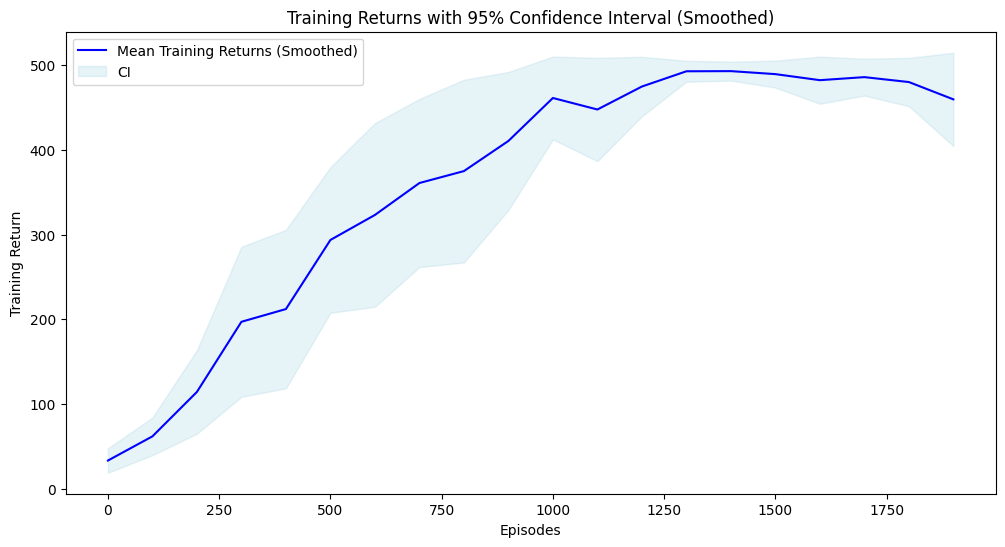

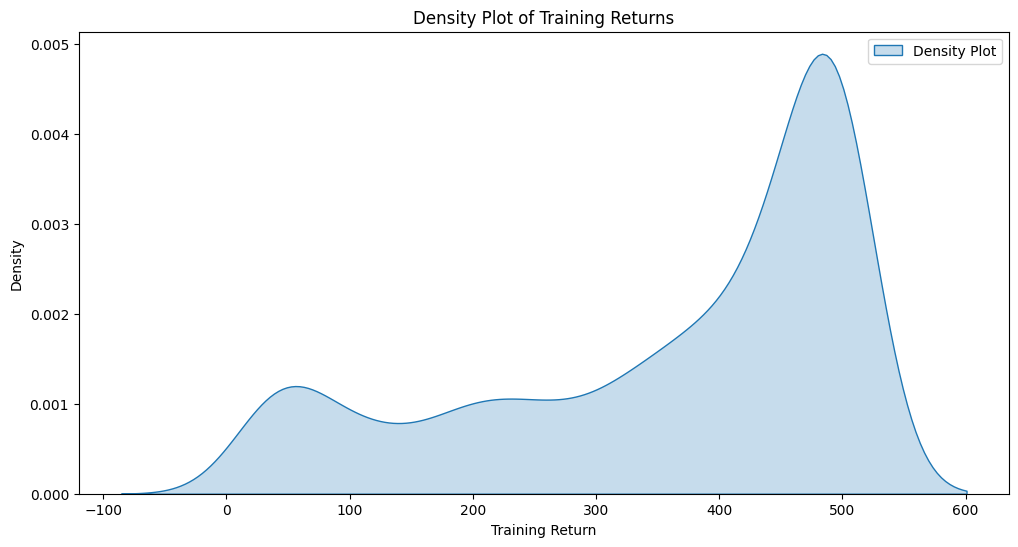

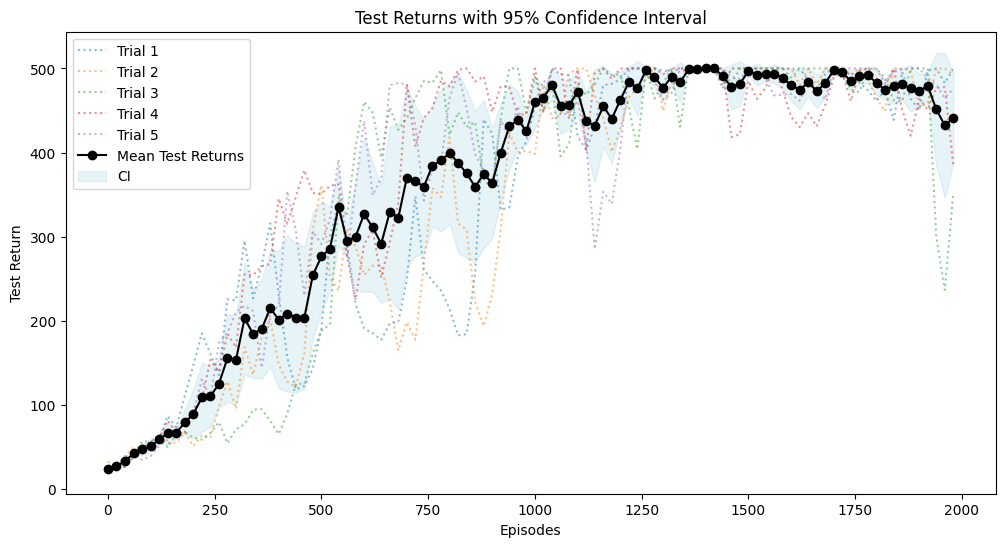

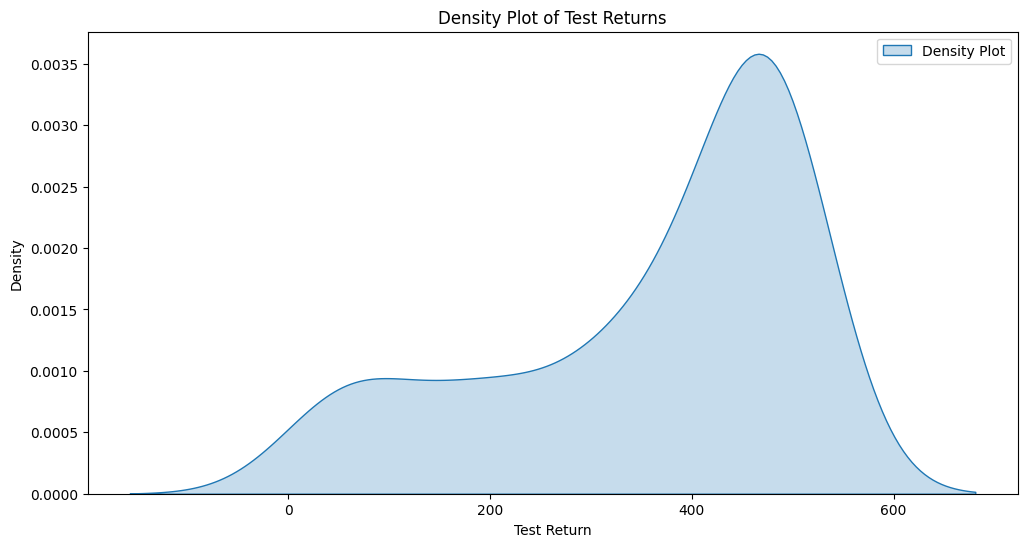

Average Returns:  [ 23.74  27.02  33.08  42.18  46.96  50.52  58.98  66.24  66.56  79.18
  88.98 108.74 110.   125.18 155.56 153.88 202.72 184.48 189.96 214.98
 201.36 208.48 203.76 203.54 254.42 276.42 285.64 335.22 294.9  300.04
 326.82 311.02 291.58 329.12 322.52 370.04 365.88 359.54 384.5  390.6
 399.26 387.9  375.1  359.28 374.26 363.94 399.92 430.98 438.94 425.46
 460.04 465.04 480.86 455.5  456.34 472.32 437.24 431.88 455.02 440.18
 462.6  483.8  476.16 497.68 489.72 477.04 490.02 483.52 498.88 498.94
 500.   499.94 491.   477.92 481.86 496.84 492.74 493.08 493.6  488.74
 480.14 474.44 483.54 472.84 482.64 497.88 495.18 484.86 490.44 492.04
 482.64 474.72 479.36 481.3  476.36 473.36 479.1  451.3  432.3  441.12]
Max Return:  500.0
Max Return 95% CI:  0.0
Individual Returns:  [500.0, 500.0, 500.0, 500.0, 500.0]


In [ ]:
def main():

    training_value = 2000
    batch_size  = 10

    # Define hyperparameters
    config_A2C = {
        'CartPole-v1': {
            'env_name': 'CartPole-v1',
            'gamma': 0.99,
            'actor_hidden_dim': 256,
            'critic_hidden_dim': 256,
            'value_dim': 1,
            'alpha': 1e-3,
            'beta': 1e-3,
            'num_training_episodes': math.ceil(training_value / batch_size),
            'num_batch_episodes': batch_size,
            't_max': 1000,
            'tau': 0.005,
            'test_interval': 20,
            'num_test_episodes': 10,
            'batch_size': batch_size
        },
        'PongNoFrameskip-v4': {
            'env_name': 'PongNoFrameskip-v4',
            'gamma': 0.99,
            'actor_hidden_dim': 512,
            'critic_hidden_dim': 512,
            'value_dim': 1,
            'alpha': 1e-4,
            'beta': 1e-4,
            'num_episodes': 5,
            't_max': 190000,
            'tau': 0.01,
            'test_interval': 100,
            'num_test_episodes': 10,
            'batch_size': 32
        }
    }

    chosen_env = 'CartPole-v1' # Change this to switch between environments

    env_params = config_A2C[chosen_env]
    env, state_dim, action_dim, action_offset = initialize_environment(env_params['env_name'])
    env.reset()

    train_params = {
        'env': env,
        'state_dim': state_dim,
        'action_dim': action_dim,
        'action_offset': action_offset,
        'gamma': env_params['gamma'],
        'actor_hidden_dim': env_params['actor_hidden_dim'],
        'critic_hidden_dim': env_params['critic_hidden_dim'],
        'value_dim': env_params['value_dim'],
        'alpha': env_params['alpha'],
        'beta': env_params['beta'],
        'num_training_episodes': env_params['num_training_episodes'],
        'num_batch_episodes': env_params['num_batch_episodes'],
        't_max': env_params['t_max'],
        'tau': env_params['tau'],
        'test_interval': env_params['test_interval'],
        'num_test_episodes': env_params['num_test_episodes'],
        'batch_size': env_params['batch_size']
    }

    num_trials = 5
    all_train_returns = []
    all_test_returns = []

    for trial in range(num_trials):
        print(f"Starting Trial {trial + 1}")
        train_rewards, test_rewards = train(**train_params)
        all_train_returns.append(train_rewards)
        all_test_returns.append(test_rewards)
        print(f"Trial {trial + 1} Completed")

    utils = Utils()
    average_returns, max_return, max_return_ci, individual_returns = utils.benchmark_plot(all_train_returns, all_test_returns, train_params['test_interval'])
    print("Average Returns: ", average_returns)
    print("Max Return: ", max_return)
    print("Max Return 95% CI: ", max_return_ci)
    print("Individual Returns: ", individual_returns)

    env.close()

if __name__ == "__main__":
    main()